### Execution on CIFAR dataset

This notebook aims to reproduce results of the paper: 

*Detection of Adversarial Attacks by Analyzing Deep Features with Multivariate Data Algorithms*


It allows to execute XGBoost on the hidden layers of CIFAR model, and reproduce our results.


For each individual layer and each individual attack:

- it trains XGBoost
- it attempts detection also on the other attacks

Different approaches/optimizations are tested, as described also in the paper. 


It requires the layers available at https://drive.google.com/drive/folders/1JsV45ooRlk5CpqFCPy-uR4iBB3Nbqx08?usp=sharing ,
folder CIFAR


We assume the CIFAR folder is located at path BASE (e.g., BASE=/home/whatever/CIFAR )


We recommend to use the conda environment available on the github.
<br><br>
<br><br>
**For brevity, we consider only the 4 best layers, 156, 105, 20, 88, and we train only on the attacks 'fgsm_0156', 'deep_10'**

This can be changed easily in the second box below.

#### Configure the following items attentively:

In [1]:
DATASET="cifar"
BATCH_SIZE=128 
EPOCH=30 #useful only for fastai; the model include a stopping criteria so no problem with high Epochs
LOGFILE="cifar_log_0_8.csv" #just a name, choose one
CPU_THREADS=32 # just to limit cpu usage, can be set to any value
RESULTS='/home/notebook/neuron/results/' #the path to the log file
BASE='/data/notebook/neuron/evadeML/cifar/'  #put your path to CIFAR folder
index_path='/home/notebook/neuron/indexes/' #path to the indexes, as available on google drive. 
                                            #These are required to properly create train and test
    
MODEL_SAVE='/home/notebook/neuron/models/' #it will save here the models it creates

From now on, everything should go smoothly (but training can be slow at some times)

The notebook will train the model, execute prediction and log results.

In [2]:
ATTACK=['bim', 'carlini_l2', 'deep_10', 'fgsm_02', 'fgsm_0156']
SUFFIX='.npy'
MAIN_ATTACK_LIST=['fgsm_0156', 'deep_10']
TOP_LAYERS=[156, 105, 20, 88]

In [3]:
from sklearn.metrics import accuracy_score
import numpy as np
import sys
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import csv
from matplotlib import pyplot as plt
import math
import fastai
from fastai.tabular.all import *
from pathlib import Path
from ipywidgets import IntProgress
from IPython.display import display
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import time
import torch
from torch import nn

%env OMP_NUM_THREADS=CPU_THREADS
%env MKL_NUM_THREADS=CPU_THREADS

torch.set_num_threads(CPU_THREADS)

env: OMP_NUM_THREADS=CPU_THREADS
env: MKL_NUM_THREADS=CPU_THREADS


Functions to load data

In [4]:
#load train data for a specific layer
def load_train(L):
    p = Path(BASE+"/train/layer_"+str(L)+".npy")
    with p.open('rb') as f:
        nptmp=np.load(f)
    return nptmp

def load_test(L):
    p = Path(BASE+"/test/layer_"+str(L)+".npy")
    with p.open('rb') as f:
        nptmp=np.load(f)
    return nptmp

#prefix, layer
def load_attack(attack, L):
    p = Path(BASE+"/"+str(attack)+"/layer_"+str(L)+".npy")
    print(p)
    with p.open('rb') as f:
        nptmp=np.load(f)
    return nptmp

def load_4_layers_train(a, b=None, c=None, d=None):
    a=load_train(a)
    if(b!=None):
        b=load_train(b)
    if(c!=None):
        c=load_train(c)
    if(d!= None):
        d=load_train(d)
    return a, b, c, d

def load_4_layers_test(a, b=None, c=None, d=None):
    a=load_test(a)
    if(b!=None):
        b=load_test(b)
    if(c!=None):
        c=load_test(c)
    if(d!= None):
        d=load_test(d)
    return a, b, c, d

def load_4_layers_attack(attack, a=None, b=None, c=None, d=None):
    a=load_attack(attack, a)
    if(b!=None):
        b=load_attack(attack, b)
    if(c!=None):
        c=load_attack(attack, c)
    if(d!= None):
        d=load_attack(attack, d)
    return a, b, c, d

Function to linearize the hidden features for a target layer and image. This allows to apply tabular data algorithms on the hidden features

In [5]:
def prod(val): 
    res = 1 
    for ele in val: 
        res *= ele 
    return res  

def linearize(numpy_linearized):
    shape_tuple=numpy_linearized.shape[1:]
    row_length=prod(list(shape_tuple))
    numpy_linearized=numpy_linearized.reshape(
        numpy_linearized.shape[0], row_length)
    return numpy_linearized

Prepare to log data

We log:

- METHOD
- how we split  (train/test)
- layer number(s)
- attack for test
- attack used for training
- DATASET (CIFAR)
- metrics: accuracy, tn, fp, fn, tp, 
- tpr when fpr is < 0.05, to compare with evadeML
- tpr when fpr is < 0.015, to compare with MagNet

In [6]:
def write_log_stacking_split(logfile, METHOD, split,approach, layer, attack, attack1, DATASET, accuracy, tn, fp, fn, tp, tpr1, tpr2):
    logfile.write( "{}, {}, {}, {}, {}, {}, {}, {:.3f}, {}, {}, {}, {}, {:.3f}, {:.3f}\n".format(METHOD,
                                    approach,
                                    split,
                                    layer,
                                    attack,
                                    attack1,
                                    DATASET,
                                    accuracy,
                                    tn, fp, fn, tp,
                                    tpr1, tpr2))
    logfile.flush()


In [7]:
f = open(RESULTS+LOGFILE, "a")

In [8]:
f.write("ALG, APPROACH, SPLIT 0.8 or 0.9, LAYER, ATTACK, TRAINED ON, DATASET, ACCURACY, TN, FP, FN, TP, TPR with FPR < 0.05, TPR with FPR < 0.015 \n")
f.flush()

The following creates the train and test datasets.

For example, they match each normal data point to label 0, and each attack data point to label 1.

In [9]:
def create_normal(normal_x):
    normal_y=np.empty([normal_x.shape[0], 1])
    normal_y.fill(0)
    return normal_x, normal_y

def create_attack(attack_x):
    attack_y=np.empty([attack_x.shape[0], 1])
    attack_y.fill(1)
    return attack_x, attack_y

def create_dataframe(x, y):
    LABEL_NUMBER=x.shape[1]
    df=pd.DataFrame(np.concatenate((x, y), axis=1))
    df[LABEL_NUMBER]=df[LABEL_NUMBER].astype(str)
    cont_names, cat_names = cont_cat_split(pd.DataFrame(x))

    return df, cont_names, cat_names, LABEL_NUMBER

def create_test_set(numpy_test_x,attack_test_x, attack_test_y):
    numpy_test_x=linearize(numpy_test_x)
    numpy_test_y=np.empty([numpy_test_x.shape[0], 1])
    numpy_test_y.fill(0)
    merged_x=np.concatenate((numpy_test_x, attack_test_x), axis=0)
    merged_y=np.concatenate((numpy_test_y, attack_test_y), axis=0)
    df=pd.DataFrame(merged_x)
    return df , merged_y

Now the training and evaluation can start:

- take a layer
- take an attack
- organize a train/test set
- do supervised train using XGBOOST
- do predict on the test set (legitimate images + attack images)
- do predict on all the other attacks


To be fair, we create a test set which includes couples of "normal image + adversarial image", and both of them have never been seen at training time. This is realised using the "indexes" folder on google drive. This is hard coded here, and cannot be parametrized. 

We provide this approach for a train-test split of 0.9 or 0.8 (default). The user can configure the test split to 0.8, just modifying TEST_SPLIT=[TEST_SPLIT_09] in TEST_SPLIT=[TEST_SPLIT_08] (and viceversa).

(Note: the test set may contain additional images, which does not have a corresponding "adversarial part").



In [10]:
#the index of the "indexes arrays" (see the folder indexes) at which we have the 0.9 train/test split for the under consideration.
#so we take all normal and adversarial images that are past such index
#this is done for each attack that is used for training
TEST_SPLIT_09=[('bim', 8834, 'bim_0.008_cifar_index_final.npy'),
               ('carlini_l2', 2375,'carlini_l2_cifar_index_final.npy'),
               ('deep_10',7945, 'deep_10_cifar_index_final.npy'),
               ('fgsm_02', 0, ''),
               ('fgsm_0156',7945, 'fgsm_0.0156_cifar_index_final.npy')]

TEST_SPLIT_08=[('bim', 7873, 'bim_0.008_cifar_index_final.npy'),
               ('carlini_l2', 7059, 'carlini_l2_cifar_index_final.npy'),
               ('deep_10',7824, 'deep_10_cifar_index_final.npy'),
               ('fgsm_02', 0, ''),
               ('fgsm_0156',7059, 'fgsm_0.0156_cifar_index_final.npy')]

TEST_SPLIT=[TEST_SPLIT_08]

list_combo= [(L, y,d)
             for L in TOP_LAYERS 
             for y in TEST_SPLIT 
             for d in MAIN_ATTACK_LIST
            ]

In [11]:
def define_attack_set(test_split, attack1, split_value, split_index,x_attack_156, x_attack_105=None, x_attack_20=None, x_attack_88=None):
    if(attack1=="bim"):
        SPLIT_PLACE=test_split[0] #bim
    elif(attack1=="carlini_l2"):
        SPLIT_PLACE=test_split[1] #carlini
    elif(attack1=="deep_10"):
        SPLIT_PLACE=test_split[2] #deep
    elif(attack1=="fgsm_02"):
        SPLIT_PLACE=test_split[3] #fgsm_02 -- data loss
    elif(attack1=="fgsm_0156"):
        SPLIT_PLACE=test_split[4] #fgsm_0156

    if(attack1=="fgsm_02"):
        index_current_attack=0
    elif(attack1=="carlini_l2"):
        index_current_attack=0
    else:
        indexes=np.load(index_path+SPLIT_PLACE[2])
        index_current_attack=np.min(np.where(indexes >= split_index))

    x_attack_156=x_attack_156[index_current_attack:]
    if(x_attack_105 is not None):
        x_attack_105=x_attack_105[index_current_attack:]
    if(x_attack_20 is not None):
        x_attack_20=x_attack_20[index_current_attack:]
    if(x_attack_88 is not None):
        x_attack_88=x_attack_88[index_current_attack:]
    return x_attack_156, x_attack_105, x_attack_20, x_attack_88

def analyze_split(test_split, attack):
    if(test_split==TEST_SPLIT_09):
        split="split:0.9"
        split_value=0.9
    else:
        split="split:0.8"
        split_value=0.8
    #create attack train and attack test
    if(attack=="fgsm_0156"):
        SPLIT_PLACE=test_split[4] #fgsm
    elif(attack=="deep_10"): #deepfool
        SPLIT_PLACE=test_split[2] #deepfool
    elif(attack=="bim"): 
        SPLIT_PLACE=test_split[0]
    elif(attack=="carlini_l2"): 
        SPLIT_PLACE=test_split[1]
    elif(attack=="fgsm_02"): 
        SPLIT_PLACE=test_split[3]

    split_index_test=SPLIT_PLACE[1]
    return split, split_value, split_index_test

def split_test_normal(x_test_156, split_index_test, x_test_105=None, x_test_20=None, x_test_88=None ):
    x_test_156=x_test_156[split_index_test:,]
    if(x_test_105 is not None):
        x_test_105=x_test_105[split_index_test:,]
    if(x_test_20 is not None):
        x_test_20=x_test_20[split_index_test:,]
    if(x_test_88 is not None):
        x_test_88=x_test_88[split_index_test:,]
    return x_test_156,x_test_105, x_test_20, x_test_88


def attack_split(attack_array, split_value):
    x_attack_train=attack_array[0:round(split_value*attack_array.shape[0])]
    x_attack_test=attack_array[round(split_value*attack_array.shape[0]):]
    return x_attack_train, x_attack_test

In [12]:
#these just computes metrics
def compute_metrics_and_log(y_test, y_attack_test, final_preds, final_preds_proba, approach, METHOD, split, layer):
    accuracy=accuracy_score(np.vstack((y_test, y_attack_test)), final_preds)
    tn, fp, fn, tp = confusion_matrix(np.vstack((y_test, y_attack_test)), final_preds, labels=[0,1]).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(np.vstack((y_test, y_attack_test)), final_preds_proba[:, 1].ravel())
    tpr_05=tpr[np.argmax(fpr[fpr<=0.05])]
    tpr_016=tpr[np.argmax(fpr[fpr<=0.016])]
    write_log_stacking_split(f, METHOD, split, approach, layer, attack, "trained on normal + {}".format(attack), 
                       DATASET, accuracy, tn, fp, fn, tp, tpr_05, tpr_016)

def compute_metrics_and_log_attacks(y_test, y_attack, final_preds, final_preds_proba, approach, METHOD, split, layer):
    accuracy=accuracy_score(y_attack, final_preds)
    tn, fp, fn, tp = confusion_matrix(y_attack, final_preds, labels=[0,1]).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(np.vstack((y_test, y_attack)),
                                                 final_preds_proba[:, 1].ravel())
    #tpr_05=tpr[np.argmax(fpr[fpr<=0.05])] not good when multiple values with the same number
    #tpr_016=tpr[np.argmax(fpr[fpr<=0.016])] not good when multiple values with the same number
    #replaced with:
    
    tpr_05=tpr[np.argwhere(fpr == np.amax(fpr[fpr<=0.05])).flatten()][-1]
    tpr_016=tpr[np.argwhere(fpr == np.amax(fpr[fpr<=0.016])).flatten()][-1]
    write_log_stacking_split(f, METHOD,split, approach, layer, attack1, attack, 
                       DATASET, accuracy, tn, fp, fn, tp, tpr_05, tpr_016)


Just a plain approach: on each layer, it applies XGBoost and compute metrics.

It saves the models that are later used.


In [13]:
for layer, test_split, attack in list_combo:
    split, split_value, split_index=analyze_split(test_split, attack)
    #load train 156, 105, 20, 88
    x_train= load_train(layer)
    y_train = np.zeros((x_train.shape[0],1))

    #load test normal 156, 105, 20, 88
    x_test= load_test(layer)
    x_test, useless1, useless2, useless3=split_test_normal(x_test,split_index)

    #y_test is built the same for all three layers
    y_test = np.zeros((x_test.shape[0],1))

    #load attacks of the three layers
    x_attack=load_attack(attack, layer)
    print("{} shape of attacks in train + test  {}".format(attack, x_attack.shape))
    
    #split also attacks, to maintain the same test & attack portion of data
    x_attack_train, x_attack_test= attack_split(x_attack, split_value)
    print("{} shape in the test set is {} after split of {}".format(attack, x_attack_test.shape,split))

    #these are OK like this for all layers
    y_attack_train=np.ones((x_attack_train.shape[0],1))
    y_attack_test=np.ones((x_attack_test.shape[0],1))

    #initialize classifier
    xgbC=xgb.XGBClassifier(nthread=CPU_THREADS,
                           use_label_encoder=False,
                           objective= 'binary:logistic',
                           eval_metric='logloss')
    #fit    
    print("now training")
    xgbC.fit(linearize(np.vstack((x_train,x_attack_train))), np.vstack((y_train, y_attack_train)))
    xgbC.save_model(MODEL_SAVE+str(attack)+'_'+str(layer)+'.model')
    xgbC.load_model(MODEL_SAVE+str(attack)+'_'+str(layer)+'.model')

    #predict on the test set and analysis of results
    print("now running predictions")
    final_preds=xgbC.predict(linearize(np.vstack((x_test, x_attack_test))))
    final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test, x_attack_test))))

    #compute metrics
    
    compute_metrics_and_log(y_test, y_attack_test, 
                            final_preds, final_preds_proba, 
                            approach= "just one layer", METHOD="XGBoost only", split=split, layer=layer)
   
    #now repeat prediction on each attack
    #we need to recover the test split applied for the other attack
    for attack1 in ATTACK:
        #load attacks of the three layers
        x_attack =load_attack(attack1, layer)

        x_attack, useless1, useless2, useless3=define_attack_set(test_split, attack1, split_value, split_index,x_attack)        
        
        y_attack_test=np.ones((x_attack.shape[0],1))
        print("{} shape after split {}".format(attack1, x_attack.shape))
        final_preds=xgbC.predict(linearize(x_attack))
        final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test,x_attack))))
        compute_metrics_and_log_attacks(y_test, y_attack_test, final_preds,
                                                             final_preds_proba,
                                                             approach= "just one layer",
                                                             METHOD="XGBoost only",
                                                             split=split, layer=layer)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
fgsm_0156 shape of attacks in train + test  (7500, 448)
fgsm_0156 shape in the test set is (1500, 448) after split of split:0.8
now training
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
bim shape after split (2403, 448)
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_156.npy
carlini_l2 shape after split (2500, 448)
/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
deep_10 shape after split (2493, 448)
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_156.npy
fgsm_02 shape after split (8981, 448)
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
fgsm_0156 shape after split (1501, 448)
/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
deep_10 shape of attacks in train + test  (9000, 448)
deep_10 shape in the test set is (1800, 448) after split of split:0.8
now training
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
bim shape after spli

We now use average pooling to reduce the size of layer 105. This can slightly improve performance if we reduce its size.

We try the following reduction parameters:

In [14]:
parameters=[ 
    #C, W, H, stride1, stride2, stride3
    (2, 3, 3, 2, 2, 2),
    (2, 3, 3, 2, 2, 1),
    (1, 6, 6, 2, 2, 1),
    (2, 6, 6, 3, 3, 1),
    (3, 6, 6, 2, 2, 2),
    (2, 4, 4, 2, 2, 1)
    ]

class NeuralNetwork(nn.Module):
    def __init__(self, C, H, W, stride1, stride2, stride3):
        super(NeuralNetwork, self).__init__()
        self.premodel_layer_1 = nn.Sequential(
            nn.AvgPool2d((H, W), stride=stride1)
        )
        self.premodel_layer_2 = nn.Sequential(
            nn.AvgPool2d((1, C), stride=(1,stride3))
        )
        
    def forward(self, out):
        out = self.premodel_layer_1(torch.tensor(out))
        out=torch.transpose(out, 1, 3)
        out = self.premodel_layer_2(out)
        out=out.detach().numpy()
        out=np.squeeze(out)
        return out


In [15]:
def linearize_fgsm_deep(attack):
    if(attack=="fgsm_0156"):
        C, H, W, stride1, stride2, stride3= 2, 4, 4, 2, 2, 1
        pre_model=NeuralNetwork(C, W, H, stride1, stride2, stride3)
    #linearize deep_10
    elif(attack=="deep_10"):
        C, H, W, stride1, stride2, stride3= 3, 6, 6, 2, 2, 2
        pre_model=NeuralNetwork(C, W, H, stride1, stride2, stride3)
    return C, H, W, stride1, stride2, stride3, pre_model

def reduce_pre_model(x_train_105, x_test_105, x_attack_105, pre_model):
    x_train_105=pre_model(x_train_105)
    x_test_105=pre_model(x_test_105)
    x_attack_105=pre_model(x_attack_105)
    return x_train_105, x_test_105, x_attack_105

The following just prints the parameters that will be tested in the next block

From running the models, it will result that the following configuration should be selected for deep_10 and fgsm_0156:

C, W, H, stride1, stride2, stride3:  (2, 4, 4, 2, 2, 1)

This reduction brings layer 105 from (8, 8, 304) to (151, 3, 7) i.e., from 19456 features values to 3171. This reduction can improve detection on layer 105. So it will be used from now on.

The corresponding models will be created with the names

*deep_10_105_244221_reduced.model*

*fgsm_0156_105_244221_reduced.model*


In [16]:
for layer, test_split, attack in list_combo:
    for param in parameters:
        if(layer != 105):
            continue
        print(attack, analyze_split(test_split, attack)[1], param)

fgsm_0156 0.8 (2, 3, 3, 2, 2, 2)
fgsm_0156 0.8 (2, 3, 3, 2, 2, 1)
fgsm_0156 0.8 (1, 6, 6, 2, 2, 1)
fgsm_0156 0.8 (2, 6, 6, 3, 3, 1)
fgsm_0156 0.8 (3, 6, 6, 2, 2, 2)
fgsm_0156 0.8 (2, 4, 4, 2, 2, 1)
deep_10 0.8 (2, 3, 3, 2, 2, 2)
deep_10 0.8 (2, 3, 3, 2, 2, 1)
deep_10 0.8 (1, 6, 6, 2, 2, 1)
deep_10 0.8 (2, 6, 6, 3, 3, 1)
deep_10 0.8 (3, 6, 6, 2, 2, 2)
deep_10 0.8 (2, 4, 4, 2, 2, 1)


In [17]:
for layer, test_split, attack in list_combo:
    for param in parameters:
        if(layer != 105):
            continue
        split, split_value, split_index=analyze_split(test_split, attack)

        #load train 105
        x_train= load_train(layer)
        y_train = np.zeros((x_train.shape[0],1))

        #load test normal 105
        x_test= load_test(layer)
        x_test, useless1, useless2, useless3=split_test_normal(x_test,split_index)

        #y_test is built the same for all three layers
        y_test = np.zeros((x_test.shape[0],1))

        #load attacks of the three layers
        x_attack=load_attack(attack, layer)
        print("{} shape of attacks in train + test  {}".format(attack, x_attack.shape))
    
        #split also attacks, to maintain the same test & attack portion of data
        x_attack_train, x_attack_test= attack_split(x_attack, split_value)
        print("{} shape in the test set is {} after split of {}".format(attack, x_attack_test.shape,split))

        #these are OK like this for all layers
        y_attack_train=np.ones((x_attack_train.shape[0],1))
        y_attack_test=np.ones((x_attack_test.shape[0],1))

        #initialize classifier
        xgbC=xgb.XGBClassifier(nthread=CPU_THREADS,
                           use_label_encoder=False,
                           objective= 'binary:logistic',
                           eval_metric='logloss')

        C, W, H, stride1, stride2, stride3=param
        pre_model=NeuralNetwork(C, W, H, stride1, stride2, stride3)
        x_train=pre_model(x_train)
        x_attack_train=pre_model(x_attack_train)
        x_test=pre_model(x_test)
        x_attack_test=pre_model(x_attack_test)
        print("shape of hidden features after avgpool is {}".format(x_train.shape[1:]))
    
        #fit    
        print("now training")
        xgbC.fit(linearize(np.vstack((x_train,x_attack_train))), np.vstack((y_train, y_attack_train)))
        xgbC.save_model(MODEL_SAVE+str(attack)+"_"+str(layer)+"_"+
                        str(C)+str(W)+str(H)+str(stride1)+str(stride2)+str(stride3)+"_reduced.model")

        #predict on the test set and analysis of results
        print("now running predictions")
        final_preds=xgbC.predict(linearize(np.vstack((x_test, x_attack_test))))
        final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test, x_attack_test))))

        #compute metrics
        compute_metrics_and_log(y_test, y_attack_test, 
                            final_preds, final_preds_proba, 
                            approach= "layer 105 with avg pool", METHOD="XGBoost only", split=split, layer=layer)
   
        #now repeat prediction on each attack
        #we need to recover the test split applied for the other attack
        for attack1 in ATTACK:
            #load attacks of the three layers
            x_attack =load_attack(attack1, layer)
            x_attack, useless1, useless2, useless3=define_attack_set(test_split, attack1, split_value, split_index,x_attack)        
        
            y_attack_test=np.ones((x_attack.shape[0],1))
            print("{} shape after split {}".format(attack1, x_attack.shape))
            x_attack=pre_model(x_attack)
            final_preds=xgbC.predict(linearize(x_attack))
            final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test,x_attack))))
            compute_metrics_and_log_attacks(y_test, y_attack_test, final_preds, final_preds_proba,
                                        approach= "layer 105 with avg pool", METHOD="XGBoost only", 
                                        split=split, layer=layer)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
fgsm_0156 shape of attacks in train + test  (7500, 8, 8, 304)
fgsm_0156 shape in the test set is (1500, 8, 8, 304) after split of split:0.8
shape of hidden features after avgpool is (151, 3, 4)
now training
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_105.npy
bim shape after split (2403, 8, 8, 304)
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_105.npy
carlini_l2 shape after split (2500, 8, 8, 304)
/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
deep_10 shape after split (2493, 8, 8, 304)
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_105.npy
fgsm_02 shape after split (8981, 8, 8, 304)
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
fgsm_0156 shape after split (1501, 8, 8, 304)
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
fgsm_0156 shape of attacks in train + test  (7500, 8, 8, 304)
fgsm_0156 shape in the test set is (1500, 8, 8, 304) after split of split:0

We now apply the same reasoning and use average pooling to reduce the size of layer 20. This can slightly improve performance if we reduce its size.


Layer 20 has shape: (32, 32, 12) i.e., 12288 parameters

In [18]:
for layer, test_split, attack in list_combo:
    for param in parameters:
        if(layer != 20):
            continue
        split, split_value, split_index=analyze_split(test_split, attack)

        #load train 20
        x_train= load_train(layer)
        y_train = np.zeros((x_train.shape[0],1))

        #load test normal 20
        x_test= load_test(layer)
        x_test, useless1, useless2, useless3=split_test_normal(x_test,split_index)

        #y_test is built the same for all three layers
        y_test = np.zeros((x_test.shape[0],1))

        #load attacks of the three layers
        x_attack=load_attack(attack, layer)
        print("{} shape of attacks in train + test  {}".format(attack, x_attack.shape))
    
        #split also attacks, to maintain the same test & attack portion of data
        x_attack_train, x_attack_test= attack_split(x_attack, split_value)
        print("{} shape in the test set is {} after split of {}".format(attack, x_attack_test.shape,split))

        #these are OK like this for all layers
        y_attack_train=np.ones((x_attack_train.shape[0],1))
        y_attack_test=np.ones((x_attack_test.shape[0],1))

        #initialize classifier
        xgbC=xgb.XGBClassifier(nthread=CPU_THREADS,
                           use_label_encoder=False,
                           objective= 'binary:logistic',
                           eval_metric='logloss')

        C, W, H, stride1, stride2, stride3=param
        pre_model=NeuralNetwork(C, W, H, stride1, stride2, stride3)
        x_train=pre_model(x_train)
        x_attack_train=pre_model(x_attack_train)
        x_test=pre_model(x_test)
        x_attack_test=pre_model(x_attack_test)
        print("shape of hidden features after avgpool is {}".format(x_train.shape[1:]))
    
        #fit    
        print("now training")
        xgbC.fit(linearize(np.vstack((x_train,x_attack_train))), np.vstack((y_train, y_attack_train)))
        xgbC.save_model(MODEL_SAVE+str(attack)+"_"+str(layer)+"_"+
                        str(C)+str(W)+str(H)+str(stride1)+str(stride2)+str(stride3)+"_reduced.model")

        #predict on the test set and analysis of results
        print("now running predictions")
        final_preds=xgbC.predict(linearize(np.vstack((x_test, x_attack_test))))
        final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test, x_attack_test))))

        #compute metrics
        compute_metrics_and_log(y_test, y_attack_test, 
                            final_preds, final_preds_proba, 
                            approach= "layer 20 with avg pool", METHOD="XGBoost only", split=split, layer=layer)
   
        #now repeat prediction on each attack
        #we need to recover the test split applied for the other attack
        for attack1 in ATTACK:
            #load attacks of the three layers
            x_attack =load_attack(attack1, layer)
            x_attack, useless1, useless2, useless3=define_attack_set(test_split, attack1, split_value, split_index,x_attack)        
        
            y_attack_test=np.ones((x_attack.shape[0],1))
            print("{} shape after split {}".format(attack1, x_attack.shape))
            x_attack=pre_model(x_attack)
            final_preds=xgbC.predict(linearize(x_attack))
            final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test,x_attack))))
            compute_metrics_and_log_attacks(y_test, y_attack_test, final_preds, final_preds_proba,
                                        approach= "layer 20 with avg pool", METHOD="XGBoost only", 
                                        split=split, layer=layer)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
fgsm_0156 shape of attacks in train + test  (7500, 32, 32, 12)
fgsm_0156 shape in the test set is (1500, 32, 32, 12) after split of split:0.8
shape of hidden features after avgpool is (5, 15, 16)
now training
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_20.npy
bim shape after split (2403, 32, 32, 12)
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_20.npy
carlini_l2 shape after split (2500, 32, 32, 12)
/data/notebook/neuron/evadeML/cifar/deep_10/layer_20.npy
deep_10 shape after split (2493, 32, 32, 12)
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_20.npy
fgsm_02 shape after split (8981, 32, 32, 12)
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
fgsm_0156 shape after split (1501, 32, 32, 12)
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
fgsm_0156 shape of attacks in train + test  (7500, 32, 32, 12)
fgsm_0156 shape in the test set is (1500, 32, 32, 12) after split of split

We now use average pooling to reduce the size of layer 88. This can slightly improve performance if we reduce its size.

Layer 88 has shape: (16, 16, 12), that is 3072 parameters.

In [19]:
for layer, test_split, attack in list_combo:
    for param in parameters:
        if(layer != 88):
            continue
        split, split_value, split_index=analyze_split(test_split, attack)

        #load train 88
        x_train= load_train(layer)
        y_train = np.zeros((x_train.shape[0],1))

        #load test normal 88
        x_test= load_test(layer)
        x_test, useless1, useless2, useless3=split_test_normal(x_test,split_index)

        #y_test is built the same for all three layers
        y_test = np.zeros((x_test.shape[0],1))

        #load attacks of the three layers
        x_attack=load_attack(attack, layer)
        print("{} shape of attacks in train + test  {}".format(attack, x_attack.shape))
    
        #split also attacks, to maintain the same test & attack portion of data
        x_attack_train, x_attack_test= attack_split(x_attack, split_value)
        print("{} shape in the test set is {} after split of {}".format(attack, x_attack_test.shape,split))

        #these are OK like this for all layers
        y_attack_train=np.ones((x_attack_train.shape[0],1))
        y_attack_test=np.ones((x_attack_test.shape[0],1))

        #initialize classifier
        xgbC=xgb.XGBClassifier(nthread=CPU_THREADS,
                           use_label_encoder=False,
                           objective= 'binary:logistic',
                           eval_metric='logloss')

        C, W, H, stride1, stride2, stride3=param
        pre_model=NeuralNetwork(C, W, H, stride1, stride2, stride3)
        x_train=pre_model(x_train)
        x_attack_train=pre_model(x_attack_train)
        x_test=pre_model(x_test)
        x_attack_test=pre_model(x_attack_test)
        print("shape of hidden features after avgpool is {}".format(x_train.shape[1:]))
    
        #fit    
        print("now training")
        xgbC.fit(linearize(np.vstack((x_train,x_attack_train))), np.vstack((y_train, y_attack_train)))
        xgbC.save_model(MODEL_SAVE+str(attack)+"_"+str(layer)+"_"+
                        str(C)+str(W)+str(H)+str(stride1)+str(stride2)+str(stride3)+"_reduced.model")

        #predict on the test set and analysis of results
        print("now running predictions")
        final_preds=xgbC.predict(linearize(np.vstack((x_test, x_attack_test))))
        final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test, x_attack_test))))

        #compute metrics
        compute_metrics_and_log(y_test, y_attack_test, 
                            final_preds, final_preds_proba, 
                            approach= "layer 88 with avg pool", METHOD="XGBoost only", split=split, layer=layer)
   
        #now repeat prediction on each attack
        #we need to recover the test split applied for the other attack
        for attack1 in ATTACK:
            #load attacks of the three layers
            x_attack =load_attack(attack1, layer)
            x_attack, useless1, useless2, useless3=define_attack_set(test_split, attack1, split_value, split_index,x_attack)        
        
            y_attack_test=np.ones((x_attack.shape[0],1))
            print("{} shape after split {}".format(attack1, x_attack.shape))
            x_attack=pre_model(x_attack)
            final_preds=xgbC.predict(linearize(x_attack))
            final_preds_proba=xgbC.predict_proba(linearize(np.vstack((x_test,x_attack))))
            compute_metrics_and_log_attacks(y_test, y_attack_test, final_preds, final_preds_proba,
                                        approach= "layer 88 with avg pool", METHOD="XGBoost only", 
                                        split=split, layer=layer)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
fgsm_0156 shape of attacks in train + test  (7500, 16, 16, 12)
fgsm_0156 shape in the test set is (1500, 16, 16, 12) after split of split:0.8
shape of hidden features after avgpool is (5, 7, 8)
now training
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_88.npy
bim shape after split (2403, 16, 16, 12)
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_88.npy
carlini_l2 shape after split (2500, 16, 16, 12)
/data/notebook/neuron/evadeML/cifar/deep_10/layer_88.npy
deep_10 shape after split (2493, 16, 16, 12)
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_88.npy
fgsm_02 shape after split (8981, 16, 16, 12)
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
fgsm_0156 shape after split (1501, 16, 16, 12)
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
fgsm_0156 shape of attacks in train + test  (7500, 16, 16, 12)
fgsm_0156 shape in the test set is (1500, 16, 16, 12) after split of split:0

Analysing the log, we can  observe that the preferred avgpool for 105 is the configuration:

- *deep_10_105_244221_reduced.model*
- *fgsm_0156_105_244221_reduced.model*

For layer 20:

- there is no actual improvement, so no reduced model is used

For layer 88, it is: 

- there is no actual improvement, so no reduced model is use


**We will use the reduced models we identfied, from now on, instead than the original model.**

Now we try 2 layers in stacking: 156 and 105, the best 2 layers we have.

In [20]:
def initialize_classifiers():
    a=xgb.XGBClassifier(nthread=CPU_THREADS,use_label_encoder=False,objective='binary:logistic',eval_metric='logloss')
    b=xgb.XGBClassifier(nthread=CPU_THREADS,use_label_encoder=False,objective='binary:logistic',eval_metric='logloss')
    c=xgb.XGBClassifier(nthread=CPU_THREADS,use_label_encoder=False,objective='binary:logistic',eval_metric='logloss')
    d=xgb.XGBClassifier(nthread=CPU_THREADS,use_label_encoder=False,objective='binary:logistic',eval_metric='logloss')    
    e=xgb.XGBClassifier(nthread=CPU_THREADS,use_label_encoder=False,objective='binary:logistic',eval_metric='logloss')    
    return a, b, c, d, e

list_combo= [(y,d)
             for y in TEST_SPLIT 
             for d in MAIN_ATTACK_LIST
            ]

In [21]:
def predict_proba_xgb(layer156,xgb_156,layer105=None, xgb_105=None,layer20=None,xgb_20=None, 
                      layer88=None, xgb_88=None):
    meta_156=xgb_156.predict_proba(linearize(layer156))
    meta_105=None
    meta_20=None
    meta_88=None #just to initialize vars
    if(layer105 is not None):
        meta_105=xgb_105.predict_proba(linearize(layer105))
    if(layer20 is not None):
        meta_20=xgb_20.predict_proba(linearize(layer20))
    if(layer88 is not None):
        meta_88=xgb_88.predict_proba(linearize(layer88))
    return meta_156, meta_105, meta_20, meta_88

#reduces layer 105 of C 2 W 4 H 4 stride1 2 stride2 2 stride3 1  
def avgpool_reduction(a,b=None,c=None, d=None):
    C, W, H, stride1, stride2, stride3=2, 4, 4, 2, 2, 1
    pre_model=NeuralNetwork(C, W, H, stride1, stride2, stride3)
    a=pre_model(a)
    if(b is not None):
        b=pre_model(b)
    if(c is not None):
        c=pre_model(c)
    if(d is not None):
        d=pre_model(d)
    return a,b,c,d

In [22]:
for test_split, attack in list_combo:
    split, split_value, split_index=analyze_split(test_split, attack)
    #load train, create y_train
    x_train_156,x_train_105,useless1, useless2= load_4_layers_train(156, 105)
    y_train = np.zeros((x_train_156.shape[0],1))
    #same for test
    x_test_156,x_test_105, useless1, useless2= load_4_layers_test(156, 105)
    x_test_156,x_test_105, useless1, useless2=split_test_normal(x_test_156, split_index, x_test_105)
    y_test = np.zeros((x_test_156.shape[0],1))
    #and for all attacks
    x_attack_156, x_attack_105, useless1, useless2=load_4_layers_attack(attack, 156, 105)
    #split attacks as usual, to maintain the same test & attack portion of data
    x_attack_train_156, x_attack_test_156= attack_split(x_attack_156, split_value)
    x_attack_train_105, x_attack_test_105= attack_split(x_attack_105, split_value)
    #these are OK like this for all layers
    y_attack_train=np.ones((x_attack_train_156.shape[0],1))
    y_attack_test=np.ones((x_attack_test_156.shape[0],1))

    #initialize all classifiers (base and stacker)
    xgb_TOT, xgb_156, xgb_105, useless1, useless2=initialize_classifiers()
    
    xgb_156.load_model(MODEL_SAVE+str(attack)+"_"+str(156)+".model")
    xgb_105.load_model(MODEL_SAVE+str(attack)+"_105_244221_reduced.model")
    
    x_train_105,x_attack_train_105,x_attack_test_105, x_test_105=avgpool_reduction(x_train_105,x_attack_train_105,x_attack_test_105, x_test_105)
    #prediction made by base classifiers (create meta-data for stacking)
    meta_156, meta_105, useless1, useless2 =predict_proba_xgb(np.vstack((x_train_156,x_attack_train_156)),xgb_156,
                                                              np.vstack((x_train_105,x_attack_train_105)),xgb_105)

    #fit the meta-learner    
    print("training meta classifier")
    xgb_TOT.fit(np.column_stack((meta_156, meta_105)), np.vstack((y_train, y_attack_train)))
    xgb_TOT.save_model(MODEL_SAVE+"xgboost_stacker_156_105.model")

    #predict on the test set and analysis of results
    print("now running predictions")
    meta_156_test_normal, meta_105_test_normal, useless1, useless2=predict_proba_xgb(x_test_156,xgb_156,
                                                                                      x_test_105,xgb_105)
    
    meta_156_test_attack,meta_105_test_attack,useless1, useless2=predict_proba_xgb(x_attack_test_156,xgb_156,
                                                                                x_attack_test_105,xgb_105)
    
    meta_test_normal=np.column_stack((meta_156_test_normal, meta_105_test_normal))
    meta_test_attack=np.column_stack((meta_156_test_attack,meta_105_test_attack))
    
    final_preds=xgb_TOT.predict(np.vstack((meta_test_normal, meta_test_attack)))

    final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal, meta_test_attack)))

    #compute metrics
    compute_metrics_and_log(y_test, y_attack_test, 
                final_preds, final_preds_proba, 
                approach= "stacking of 156 and 105", METHOD="XGBoost only", split=split, layer=None)


    #now repeat prediction on each attack
    #we would need to recover the test split from the other one
    for attack1 in ATTACK:
        #load attacks of the three layers
        x_attack_156, x_attack_105, useless1, useless2 =load_4_layers_attack(attack1, 156, 105)

        x_attack_156, x_attack_105, useless1, useless2=define_attack_set(test_split, attack1, split_value, split_index,x_attack_156, x_attack_105)

        x_attack_105,useless1,useless2, useless3=avgpool_reduction(x_attack_105)
        
        y_attack_test=np.ones((x_attack_156.shape[0],1))
        meta_156,meta_105,useless1, useless2=predict_proba_xgb(x_attack_156,xgb_156,x_attack_105, xgb_105)
    
        meta_test_attack=np.column_stack((meta_156, meta_105))
        final_preds=xgb_TOT.predict(meta_test_attack)
        final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal,meta_test_attack)))

        compute_metrics_and_log_attacks(y_test, y_attack_test, 
                    final_preds, final_preds_proba, 
                    approach= "stacking of 156 and 105", METHOD="XGBoost only", split=split, layer=None)

/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
training meta classifier
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
/data/notebook/neuron/evadeML/cifar/bim/layer_105.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_156.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_105.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_156.npy
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_105.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
training meta classifier
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
/data/notebook/neuron/evadeML/

Now we try 3 layers in stacking: 156, 105, 20, the best 3 layers we have.

In [23]:
for test_split, attack in list_combo:
    split, split_value, split_index=analyze_split(test_split, attack)
    #load train, create y_train
    x_train_156,x_train_105,x_train_20, useless2= load_4_layers_train(156, 105, 20)
    y_train = np.zeros((x_train_156.shape[0],1))
    #same for test
    x_test_156,x_test_105, x_test_20, useless2= load_4_layers_test(156, 105, 20)
    x_test_156,x_test_105, x_test_20, useless2=split_test_normal(x_test_156, split_index, x_test_105, x_test_20)
    y_test = np.zeros((x_test_156.shape[0],1))
    #and for all attacks
    x_attack_156, x_attack_105, x_attack_20, useless2=load_4_layers_attack(attack, 156, 105, 20)
    #split attacks as usual, to maintain the same test & attack portion of data
    x_attack_train_156, x_attack_test_156= attack_split(x_attack_156, split_value)
    x_attack_train_105, x_attack_test_105= attack_split(x_attack_105, split_value)
    x_attack_train_20, x_attack_test_20= attack_split(x_attack_20, split_value)
    #these are OK like this for all layers
    y_attack_train=np.ones((x_attack_train_156.shape[0],1))
    y_attack_test=np.ones((x_attack_test_156.shape[0],1))

    #initialize all classifiers (base and stacker)
    xgb_TOT, xgb_156, xgb_105, xgb_20, useless2=initialize_classifiers()
    
    xgb_156.load_model(MODEL_SAVE+str(attack)+"_"+str(156)+".model")
    xgb_105.load_model(MODEL_SAVE+str(attack)+"_105_244221_reduced.model")
    xgb_20.load_model(MODEL_SAVE+str(attack)+"_"+str(20)+".model")
    
    x_train_105,x_attack_train_105,x_attack_test_105, x_test_105=avgpool_reduction(x_train_105,x_attack_train_105,x_attack_test_105, x_test_105)
    
    #prediction made by base classifiers (create meta-data for stacking)
    meta_156, meta_105, meta_20, useless2 =predict_proba_xgb(np.vstack((x_train_156,x_attack_train_156)),xgb_156,
                                                              np.vstack((x_train_105,x_attack_train_105)),xgb_105,
                                                              np.vstack((x_train_20,x_attack_train_20)),xgb_20,
                                                            )

    #fit the meta-learner    
    print("training meta classifier")
    xgb_TOT.fit(np.column_stack((meta_156, meta_105, meta_20)), np.vstack((y_train, y_attack_train)))
    xgb_TOT.save_model(MODEL_SAVE+"xgboost_stacker_156_105_20.model")

    #predict on the test set and analysis of results
    print("now running predictions")
    meta_156_test_normal, meta_105_test_normal, meta_20_test_normal, useless2=predict_proba_xgb(x_test_156,xgb_156,
                                                                                      x_test_105,xgb_105,
                                                                                      x_test_20,xgb_20)
    
    meta_156_test_attack,meta_105_test_attack,meta_20_test_attack, useless2=predict_proba_xgb(x_attack_test_156,xgb_156,
                                                                                x_attack_test_105,xgb_105,
                                                                                x_attack_test_20,xgb_20)
    
    meta_test_normal=np.column_stack((meta_156_test_normal, meta_105_test_normal,meta_20_test_normal))
    meta_test_attack=np.column_stack((meta_156_test_attack,meta_105_test_attack,meta_20_test_attack))
    
    final_preds=xgb_TOT.predict(np.vstack((meta_test_normal, meta_test_attack)))

    final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal, meta_test_attack)))

    #compute metrics
    compute_metrics_and_log(y_test, y_attack_test, 
                final_preds, final_preds_proba, 
                approach= "stacking of 156-105-20", METHOD="XGBoost only", split=split, layer=None)


    #now repeat prediction on each attack
    #we would need to recover the test split from the other one
    for attack1 in ATTACK:
        #load attacks of the three layers
        x_attack_156, x_attack_105, x_attack_20, useless2 =load_4_layers_attack(attack1, 156, 105, 20)

        x_attack_156, x_attack_105, x_attack_20, useless2=define_attack_set(test_split, attack1, split_value, split_index,x_attack_156, x_attack_105, x_attack_20)
        x_attack_105, useless1,useless2, useless3=avgpool_reduction(x_attack_105)
        
        y_attack_test=np.ones((x_attack_156.shape[0],1))

        meta_156,meta_105,meta_20, useless2=predict_proba_xgb(x_attack_156,xgb_156,x_attack_105, xgb_105,x_attack_20, xgb_20)
    
        meta_test_attack=np.column_stack((meta_156, meta_105, meta_20))
        final_preds=xgb_TOT.predict(meta_test_attack)
        final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal,meta_test_attack)))

        compute_metrics_and_log_attacks(y_test, y_attack_test, 
                    final_preds, final_preds_proba, 
                    approach= "stacking of 156-105-20", METHOD="XGBoost only", split=split, layer=None)

/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
training meta classifier
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
/data/notebook/neuron/evadeML/cifar/bim/layer_105.npy
/data/notebook/neuron/evadeML/cifar/bim/layer_20.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_156.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_105.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_20.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_20.npy
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_156.npy
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_105.npy
/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_20.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
/data/notebook/neuron/e

Now we try 4 layers in stacking: 156, 105, 20, 88

We should notice a very slight improvement.

In [24]:
for test_split, attack in list_combo:
    split, split_value, split_index=analyze_split(test_split, attack)
    #load train, create y_train
    x_train_156,x_train_105,x_train_20, x_train_88= load_4_layers_train(156, 105, 20, 88)
    y_train = np.zeros((x_train_156.shape[0],1))
    #same for test
    x_test_156,x_test_105, x_test_20, x_test_88= load_4_layers_test(156, 105, 20,88)
    x_test_156,x_test_105, x_test_20, x_test_88=split_test_normal(x_test_156, split_index, x_test_105, x_test_20, x_test_88)
    y_test = np.zeros((x_test_156.shape[0],1))
    #and for all attacks
    x_attack_156, x_attack_105, x_attack_20,x_attack_88=load_4_layers_attack(attack, 156, 105, 20, 88)
    #split attacks as usual, to maintain the same test & attack portion of data
    x_attack_train_156, x_attack_test_156= attack_split(x_attack_156, split_value)
    x_attack_train_105, x_attack_test_105= attack_split(x_attack_105, split_value)
    x_attack_train_20, x_attack_test_20= attack_split(x_attack_20, split_value)
    x_attack_train_88, x_attack_test_88= attack_split(x_attack_88, split_value)
    #these are OK like this for all layers
    y_attack_train=np.ones((x_attack_train_156.shape[0],1))
    y_attack_test=np.ones((x_attack_test_156.shape[0],1))

    #initialize all classifiers (base and stacker)
    xgb_TOT, xgb_156, xgb_105, xgb_20,xgb_88=initialize_classifiers()
    
    xgb_156.load_model(MODEL_SAVE+str(attack)+"_"+str(156)+".model")
    xgb_105.load_model(MODEL_SAVE+str(attack)+"_105_244221_reduced.model")
    xgb_20.load_model(MODEL_SAVE+str(attack)+"_"+str(20)+".model")
    xgb_88.load_model(MODEL_SAVE+str(attack)+"_"+str(88)+".model")

    #avgpool on 105 as usual
    x_train_105,x_attack_train_105,x_attack_test_105, x_test_105=avgpool_reduction(x_train_105,x_attack_train_105,x_attack_test_105, x_test_105)
    #prediction made by base classifiers (create meta-data for stacking)
    meta_156, meta_105, meta_20, meta_88 =predict_proba_xgb(np.vstack((x_train_156,x_attack_train_156)),xgb_156,
                                                              np.vstack((x_train_105,x_attack_train_105)),xgb_105,
                                                              np.vstack((x_train_20,x_attack_train_20)),xgb_20,
                                                              np.vstack((x_train_88,x_attack_train_88)),xgb_88,
                                                           )

    #fit the meta-learner    
    print("training meta classifier")
    xgb_TOT.fit(np.column_stack((meta_156, meta_105, meta_20,meta_88)), np.vstack((y_train, y_attack_train)))
    xgb_TOT.save_model(MODEL_SAVE+"xgboost_stacker_156_105_20_88.model")

    #predict on the test set and analysis of results
    print("now running predictions")
    meta_156_test_normal, meta_105_test_normal, meta_20_test_normal, meta_88_test_normal=predict_proba_xgb(x_test_156,xgb_156,
                                                                                      x_test_105,xgb_105,
                                                                                      x_test_20,xgb_20,
                                                                                      x_test_88,xgb_88)
    
    meta_156_test_attack,meta_105_test_attack,meta_20_test_attack, meta_88_test_attack=predict_proba_xgb(x_attack_test_156,xgb_156,
                                                                                x_attack_test_105,xgb_105,
                                                                                x_attack_test_20,xgb_20,
                                                                                x_attack_test_88,xgb_88)
    
    meta_test_normal=np.column_stack((meta_156_test_normal, meta_105_test_normal,meta_20_test_normal,meta_88_test_normal ))
    meta_test_attack=np.column_stack((meta_156_test_attack,meta_105_test_attack,meta_20_test_attack,meta_88_test_attack))
    
    final_preds=xgb_TOT.predict(np.vstack((meta_test_normal, meta_test_attack)))

    final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal, meta_test_attack)))

    #compute metrics
    compute_metrics_and_log(y_test, y_attack_test, 
                final_preds, final_preds_proba, 
                approach= "stacking of 156-105-20-88", METHOD="XGBoost only", split=split, layer=None)

    #now repeat prediction on each attack
    #we would need to recover the test split from the other one
    for attack1 in ATTACK:
        #load attacks of the three layers
        x_attack_156, x_attack_105, x_attack_20, x_attack_88 =load_4_layers_attack(attack1, 156, 105, 20,88)

        x_attack_156, x_attack_105, x_attack_20, x_attack_88=define_attack_set(test_split, attack1, 
                                                                               split_value, split_index,
                                                                               x_attack_156, x_attack_105, x_attack_20,x_attack_88)
        
        x_attack_105, useless1,useless2, useless3=avgpool_reduction(x_attack_105)

        y_attack_test=np.ones((x_attack_156.shape[0],1))
        meta_156,meta_105,meta_20,meta_88=predict_proba_xgb(x_attack_156,xgb_156,x_attack_105, xgb_105,x_attack_20, xgb_20,x_attack_88, xgb_88)
    
        meta_test_attack=np.column_stack((meta_156, meta_105, meta_20, meta_88))
        final_preds=xgb_TOT.predict(meta_test_attack)
        final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal,meta_test_attack)))

        compute_metrics_and_log_attacks(y_test, y_attack_test, 
                    final_preds, final_preds_proba, 
                    approach= "stacking of 156-105-20-88", METHOD="XGBoost only", split=split, layer=None)

/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
training meta classifier
now running predictions
/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
/data/notebook/neuron/evadeML/cifar/bim/layer_105.npy
/data/notebook/neuron/evadeML/cifar/bim/layer_20.npy
/data/notebook/neuron/evadeML/cifar/bim/layer_88.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_156.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_105.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_20.npy
/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_88.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_20.npy
/data/notebook/neuron/evadeML/cifar/deep_10/layer_88.npy
/data/notebook/neuron/evade

We compare results with XGBoost using another method for tabular data. We select fastai, because it has some nice preprocessing activities. 

First, we compute fastai on each layer.


In [25]:
def trainFastai_one_layer(x_train_156,x_attack_train_156,y_train, y_attack_train):

    df,cont_names, cat_names, label =create_dataframe(linearize(np.vstack((x_train_156,x_attack_train_156))),
                                                      np.vstack((y_train, y_attack_train)))
    split = RandomSplitter(valid_pct=VAL_SPLIT, seed=42)(range_of(df))    
    to = TabularPandas(df,procs=[Categorify, FillMissing, Normalize],
                       cat_names = cat_names,
                       cont_names = cont_names,
                       y_names=label,
                       splits=split,
                       reduce_memory=True)

    dls_156 = to.dataloaders(bs=BATCH_SIZE)#, device=torch.device('cuda'))
    fastai_156=tabular_learner(dls_156, metrics=accuracy)
    fastai_156.fit_one_cycle(EPOCH, cbs=[ShowGraphCallback(),
                                         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=3)])
    
    return fastai_156, dls_156


def predict_proba_fastai(x_train, fastai_156, dls_156):
    df1=pd.DataFrame(linearize(x_train))
    dl1 = dls_156.test_dl(df1, bs=BATCH_SIZE)#, device=torch.device('cuda')) # apply transforms
    meta_156_fastai,  _ = fastai_156.get_preds(dl=dl1) # get prediction
    meta_156_fastai=meta_156_fastai.numpy()
    return meta_156_fastai


def predict_fastai(x_train, fastai_156, dls_156):
    df1=pd.DataFrame(linearize(x_train))
    dl1 = dls_156.test_dl(df1, bs=BATCH_SIZE)#, device=torch.device('cuda')) # apply transforms
    meta_156_fastai,  _ = fastai_156.get_preds(dl=dl1) # get prediction
    meta_156_fastai=meta_156_fastai.numpy()
    return meta_156_fastai


In [26]:
list_combo= [(L, y,d)
             for L in TOP_LAYERS 
             for y in TEST_SPLIT 
             for d in MAIN_ATTACK_LIST
            ]

VAL_SPLIT=0.2
import pickle

/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
fgsm_0156 shape of attacks in train + test  (7500, 448)
fgsm_0156 shape in the test set is (1500, 448) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.471252,0.476282,0.866161,00:04
1,0.235972,0.765796,0.965268,00:05
2,0.099868,0.108820,0.973482,00:03
3,0.078559,0.072527,0.974554,00:04
4,0.060943,0.064260,0.975000,00:03
5,0.058959,0.081907,0.974286,00:04
6,0.054634,0.054715,0.978929,00:04
7,0.046093,0.069033,0.979196,00:04
8,0.044581,0.075000,0.978214,00:04
9,0.036408,0.057159,0.979464,00:04


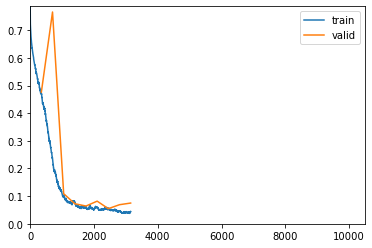

No improvement since epoch 6: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
bim shape after split (2403, 448)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_156.npy
carlini_l2 shape after split (2500, 448)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
deep_10 shape after split (2493, 448)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_156.npy
fgsm_02 shape after split (8981, 448)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
fgsm_0156 shape after split (1501, 448)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
deep_10 shape of attacks in train + test  (9000, 448)
deep_10 shape in the test set is (1800, 448) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.433819,0.495893,0.862587,00:04
1,0.224946,0.334456,0.947640,00:03
2,0.150219,0.187734,0.957780,00:04
3,0.132606,0.127256,0.958654,00:03
4,0.123170,0.122885,0.959615,00:03
5,0.121129,0.135488,0.958392,00:04
6,0.111303,0.124489,0.961101,00:06
7,0.103020,0.127068,0.958741,00:06


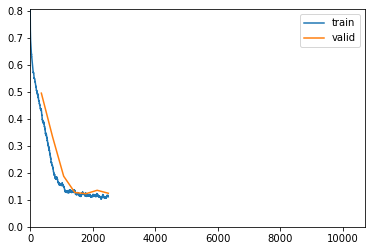

No improvement since epoch 4: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_156.npy
bim shape after split (1743, 448)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_156.npy
carlini_l2 shape after split (2500, 448)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_156.npy
deep_10 shape after split (1801, 448)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_156.npy
fgsm_02 shape after split (8981, 448)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
fgsm_0156 shape after split (852, 448)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
fgsm_0156 shape of attacks in train + test  (7500, 8, 8, 304)
fgsm_0156 shape in the test set is (1500, 8, 8, 304) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.416780,0.372557,0.915446,00:12
1,0.223640,0.212751,0.958125,00:10
2,0.104131,0.095770,0.971161,00:10
3,0.077896,0.073621,0.975804,00:10
4,0.063115,0.067374,0.975446,00:10
5,0.058563,0.078018,0.970982,00:11
6,0.045517,0.054397,0.980179,00:11
7,0.035854,0.061452,0.977679,00:11
8,0.031900,0.063390,0.977589,00:10
9,0.021380,0.070507,0.978036,00:11


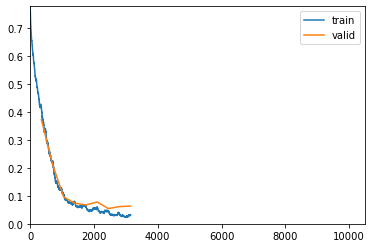

No improvement since epoch 6: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_105.npy
bim shape after split (2403, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_105.npy
carlini_l2 shape after split (2500, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
deep_10 shape after split (2493, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_105.npy
fgsm_02 shape after split (8981, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
fgsm_0156 shape after split (1501, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
deep_10 shape of attacks in train + test  (9000, 8, 8, 304)
deep_10 shape in the test set is (1800, 8, 8, 304) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.303373,0.258047,0.950175,00:09
1,0.167357,0.139254,0.963112,00:09
2,0.128447,0.113801,0.966084,00:10
3,0.114842,0.109423,0.966958,00:11
4,0.101517,0.110761,0.965822,00:10
5,0.096227,0.109394,0.967657,00:10
6,0.082290,0.114971,0.966434,00:11


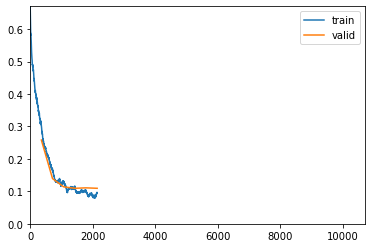

No improvement since epoch 3: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_105.npy
bim shape after split (1743, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_105.npy
carlini_l2 shape after split (2500, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_105.npy
deep_10 shape after split (1801, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_105.npy
fgsm_02 shape after split (8981, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
fgsm_0156 shape after split (852, 151, 3, 7)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
fgsm_0156 shape of attacks in train + test  (7500, 32, 32, 12)
fgsm_0156 shape in the test set is (1500, 32, 32, 12) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.636284,0.621350,0.683750,00:26
1,0.441205,0.436189,0.849107,00:25
2,0.208635,0.277141,0.891339,00:25
3,0.142869,0.270163,0.902054,00:26
4,0.104940,0.271943,0.911696,00:25
5,0.081670,0.282896,0.916071,00:26
6,0.062649,0.280319,0.919732,00:26


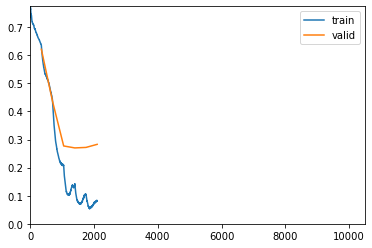

No improvement since epoch 3: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_20.npy
bim shape after split (2403, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_20.npy
carlini_l2 shape after split (2500, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_20.npy
deep_10 shape after split (2493, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_20.npy
fgsm_02 shape after split (8981, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
fgsm_0156 shape after split (1501, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_20.npy
deep_10 shape of attacks in train + test  (9000, 32, 32, 12)
deep_10 shape in the test set is (1800, 32, 32, 12) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.560337,0.537449,0.821504,00:31
1,0.381067,0.360533,0.894843,00:31
2,0.223574,0.273266,0.909091,00:28
3,0.179435,0.281289,0.909790,00:27
4,0.141882,0.303080,0.911276,00:28
5,0.104478,0.325955,0.912413,00:27


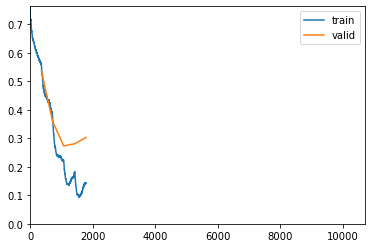

No improvement since epoch 2: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_20.npy
bim shape after split (1743, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_20.npy
carlini_l2 shape after split (2500, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_20.npy
deep_10 shape after split (1801, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_20.npy
fgsm_02 shape after split (8981, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
fgsm_0156 shape after split (852, 32, 32, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
fgsm_0156 shape of attacks in train + test  (7500, 16, 16, 12)
fgsm_0156 shape in the test set is (1500, 16, 16, 12) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.541184,0.504791,0.839107,00:08
1,0.328763,0.322568,0.927679,00:08
2,0.156477,0.164059,0.946607,00:08
3,0.111477,0.149382,0.946429,00:08
4,0.090311,0.159452,0.943661,00:09
5,0.073999,0.143397,0.948839,00:09
6,0.057118,0.143644,0.951518,00:08
7,0.043903,0.153252,0.951696,00:08
8,0.032852,0.158669,0.948393,00:09


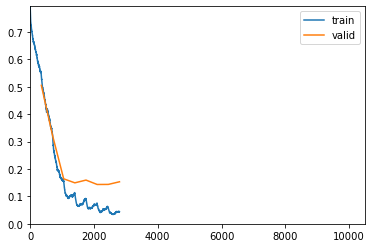

No improvement since epoch 5: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_88.npy
bim shape after split (2403, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_88.npy
carlini_l2 shape after split (2500, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_88.npy
deep_10 shape after split (2493, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_88.npy
fgsm_02 shape after split (8981, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
fgsm_0156 shape after split (1501, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_88.npy
deep_10 shape of attacks in train + test  (9000, 16, 16, 12)
deep_10 shape in the test set is (1800, 16, 16, 12) after split of split:0.8


epoch,train_loss,valid_loss,accuracy,time
0,0.419170,0.345865,0.909353,00:08
1,0.256759,0.235352,0.935927,00:08
2,0.174438,0.182461,0.943007,00:08
3,0.138610,0.169495,0.943182,00:09
4,0.120487,0.178539,0.942745,00:09
5,0.094688,0.187387,0.941608,00:09
6,0.082957,0.195396,0.942220,00:08


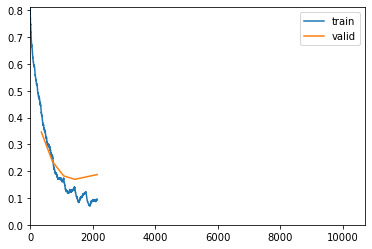

No improvement since epoch 3: early stopping


/tmp/ipykernel_5935/1823171739.py:38: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pickle.dump(dls_model, pickle_file, protocol=4.0)


now running predictions


/data/notebook/neuron/evadeML/cifar/bim/layer_88.npy
bim shape after split (1743, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/carlini_l2/layer_88.npy
carlini_l2 shape after split (2500, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/deep_10/layer_88.npy
deep_10 shape after split (1801, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_02/layer_88.npy
fgsm_02 shape after split (8981, 16, 16, 12)


/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
fgsm_0156 shape after split (852, 16, 16, 12)


In [27]:
for layer, test_split, attack in list_combo:
    %reset_selective -f to, dls, learn, split
    import fastai
    from fastai.tabular.all import *
    split, split_value, split_index=analyze_split(test_split, attack)

    #load train 156, 105, 20, 88
    x_train= load_train(layer)
    y_train = np.zeros((x_train.shape[0],1))

    #load test normal 156, 105, 20, 88
    x_test= load_test(layer)
    x_test, useless1, useless2, useless3=split_test_normal(x_test,split_index)

    #y_test is built the same for all three layers
    y_test = np.zeros((x_test.shape[0],1))

    #load attacks of the layers
    x_attack=load_attack(attack, layer)
    print("{} shape of attacks in train + test  {}".format(attack, x_attack.shape))
    
    #split also attacks, to maintain the same test & attack portion of data
    x_attack_train, x_attack_test= attack_split(x_attack, split_value)
    print("{} shape in the test set is {} after split of {}".format(attack, x_attack_test.shape,split))

    #these are OK like this for all layers
    y_attack_train=np.ones((x_attack_train.shape[0],1))
    y_attack_test=np.ones((x_attack_test.shape[0],1))

    #avgpool on 105
    if(layer==105):
        x_train,x_attack_train,x_attack_test,x_test=avgpool_reduction(x_train,x_attack_train,x_attack_test,x_test)

    #train fastai and save model
    fastai_model, dls_model=trainFastai_one_layer(x_train,x_attack_train,y_train, y_attack_train)
    fastai_model.save(MODEL_SAVE+"fastai_"+str(attack)+"_"+str(layer))
    with open(MODEL_SAVE+"dls_fastai_"+str(attack)+"_"+str(layer), 'wb') as pickle_file:
        pickle.dump(dls_model, pickle_file, protocol=4.0)


    #predict on the test set and analysis of results
    print("now running predictions")
    final_preds_proba=predict_proba_fastai(np.vstack((x_test, x_attack_test)), fastai_model, dls_model)
    final_preds = np.argmax(final_preds_proba, axis=1)

    #compute metrics
    compute_metrics_and_log(y_test, y_attack_test, 
                            final_preds, final_preds_proba, 
                            approach= "just one layer", METHOD="FastAI only", split=split, layer=layer)
   
    #now repeat prediction on each attack
    #we need to recover the test split applied for the other attack
    for attack1 in ATTACK:
        #load attacks of the layer
        x_attack =load_attack(attack1, layer)
        if(layer==105):
            x_attack, useless1, useless2, useless3=avgpool_reduction(x_attack)

        x_attack, useless1, useless2, useless3=define_attack_set(test_split, attack1, split_value, split_index,x_attack)        
        
        y_attack_test=np.ones((x_attack.shape[0],1))
        print("{} shape after split {}".format(attack1, x_attack.shape))
        final_preds_proba=predict_proba_fastai(np.vstack((x_test,x_attack)),fastai_model, dls_model)
        final_preds=predict_proba_fastai(x_attack,fastai_model, dls_model)
        final_preds = np.argmax(final_preds, axis=1)
        
        compute_metrics_and_log_attacks(y_test, y_attack_test, final_preds, final_preds_proba,
                                        approach= "just one layer", METHOD="FastAI only", split=split, layer=layer)

At this point, we complement the stacking on XGBOOST using fastai base learners, to see if there is any improvement and to understand if XGBoost is better than fastai.

In [28]:
list_combo= [(y,d)
             for y in TEST_SPLIT 
             for d in MAIN_ATTACK_LIST
            ]

In [ ]:
for test_split, attack in list_combo:
    %reset_selective -f to, dls, learn, split
    import fastai
    from fastai.tabular.all import *
    
    split, split_value, split_index=analyze_split(test_split, attack)
    #load train, create y_train
    x_train_156,x_train_105,x_train_20, x_train_88= load_4_layers_train(156, 105, 20, 88)
    y_train = np.zeros((x_train_156.shape[0],1))
    #same for test
    x_test_156,x_test_105, x_test_20, x_test_88= load_4_layers_test(156, 105, 20, 88)
    x_test_156,x_test_105, x_test_20, x_test_88=split_test_normal(x_test_156, split_index, x_test_105, x_test_20, x_test_88)
    y_test = np.zeros((x_test_156.shape[0],1))
    #and for all attacks
    x_attack_156, x_attack_105, x_attack_20,x_attack_88=load_4_layers_attack(attack, 156, 105, 20, 88)
    #split attacks as usual, to maintain the same test & attack portion of data
    x_attack_train_156, x_attack_test_156= attack_split(x_attack_156, split_value)
    x_attack_train_105, x_attack_test_105= attack_split(x_attack_105, split_value)
    x_attack_train_20, x_attack_test_20= attack_split(x_attack_20, split_value)
    x_attack_train_88, x_attack_test_88= attack_split(x_attack_88, split_value)
    #these are OK like this for all layers
    y_attack_train=np.ones((x_attack_train_156.shape[0],1))
    y_attack_test=np.ones((x_attack_test_156.shape[0],1))

    #initialize all classifiers (base and stacker)
    xgb_TOT, xgb_156, xgb_105, xgb_20,xgb_88=initialize_classifiers()
    
    xgb_156.load_model(MODEL_SAVE+str(attack)+"_"+str(156)+".model")
    xgb_105.load_model(MODEL_SAVE+str(attack)+"_105_244221_reduced.model")
    xgb_20.load_model(MODEL_SAVE+str(attack)+"_"+str(20)+".model")
    xgb_88.load_model(MODEL_SAVE+str(attack)+"_"+str(88)+".model")

    #initialize fastai classifiers
    with open(MODEL_SAVE+"dls_fastai_"+str(attack)+"_"+str(156), 'rb') as pickle_file:
        dls_156=pickle.load(pickle_file)
    fastai_156=tabular_learner(dls_156, metrics=accuracy)
    fastai_156.load(MODEL_SAVE+"fastai_"+str(attack)+"_"+str(156))
    with open(MODEL_SAVE+"dls_fastai_"+str(attack)+"_"+str(105), 'rb') as pickle_file:
        dls_105=pickle.load(pickle_file)
    fastai_105=tabular_learner(dls_105, metrics=accuracy)
    fastai_105.load(MODEL_SAVE+"fastai_"+str(attack)+"_"+str(105))
    with open(MODEL_SAVE+"dls_fastai_"+str(attack)+"_"+str(20), 'rb') as pickle_file:
        dls_20=pickle.load(pickle_file)
    fastai_20=tabular_learner(dls_20, metrics=accuracy)
    fastai_20.load(MODEL_SAVE+"fastai_"+str(attack)+"_"+str(20))
    with open(MODEL_SAVE+"dls_fastai_"+str(attack)+"_"+str(88), 'rb') as pickle_file:
        dls_88=pickle.load(pickle_file)
    fastai_88=tabular_learner(dls_88, metrics=accuracy)
    fastai_88.load(MODEL_SAVE+"fastai_"+str(attack)+"_"+str(88))
    
    #avgpool on 105 as usual
    x_train_105,x_attack_train_105,x_attack_test_105, x_test_105=avgpool_reduction(x_train_105,x_attack_train_105,x_attack_test_105, x_test_105)

    #prediction made by base classifiers (create meta-data for stacking)
    meta_156_xgb, meta_105_xgb, meta_20_xgb, meta_88_xgb =predict_proba_xgb(np.vstack((x_train_156,x_attack_train_156)),xgb_156,
                                                              np.vstack((x_train_105,x_attack_train_105)),xgb_105,
                                                              np.vstack((x_train_20,x_attack_train_20)),xgb_20,
                                                              np.vstack((x_train_88,x_attack_train_88)),xgb_88,
                                                           )
    print("fastai predict on training set")

    meta_156_fastai= predict_proba_fastai(np.vstack((x_train_156,x_attack_train_156)),fastai_156,dls_156)
    meta_105_fastai= predict_proba_fastai(np.vstack((x_train_105,x_attack_train_105)),fastai_105,dls_105)
    meta_20_fastai=predict_proba_fastai(np.vstack((x_train_20,x_attack_train_20)), fastai_20, dls_20)
    meta_88_fastai= predict_proba_fastai(np.vstack((x_train_88,x_attack_train_88)), fastai_88, dls_88)

    #fit the meta-learner    
    print("training meta classifier")
    xgb_TOT.fit(np.column_stack((meta_156_xgb, meta_105_xgb, meta_20_xgb, meta_88_xgb,
                                meta_156_fastai,meta_105_fastai,meta_20_fastai,meta_88_fastai)),
                                np.vstack((y_train, y_attack_train)))
    xgb_TOT.save_model(MODEL_SAVE+"xgboost_fastai_stacker_156_105_20_88.model")

    #predict on the test set and analysis of results
    print("now running predictions")
    meta_156_test_normal_xgb, meta_105_test_normal_xgb, meta_20_test_normal_xgb, meta_88_test_normal_xgb=predict_proba_xgb(x_test_156,xgb_156,
                                                                                      x_test_105,xgb_105,
                                                                                      x_test_20,xgb_20,
                                                                                      x_test_88,xgb_88)
    
    meta_156_test_attack_xgb,meta_105_test_attack_xgb,meta_20_test_attack_xgb, meta_88_test_attack_xgb=predict_proba_xgb(x_attack_test_156,xgb_156,
                                                                                x_attack_test_105,xgb_105,
                                                                                x_attack_test_20,xgb_20,
                                                                                x_attack_test_88,xgb_88)

    
    meta_156_test_fastai= predict_proba_fastai(x_test_156,fastai_156,dls_156)
    meta_105_test_fastai= predict_proba_fastai(x_test_105,fastai_105,dls_105)
    meta_20_test_fastai=predict_proba_fastai(x_test_20, fastai_20, dls_20)
    meta_88_test_fastai= predict_proba_fastai(x_test_88, fastai_88, dls_88)

    meta_156_test_attack_fastai= predict_proba_fastai(x_attack_test_156,fastai_156,dls_156)
    meta_105_test_attack_fastai= predict_proba_fastai(x_attack_test_105,fastai_105,dls_105)
    meta_20_test_attack_fastai=predict_proba_fastai(x_attack_test_20, fastai_20, dls_20)
    meta_88_test_attack_fastai= predict_proba_fastai(x_attack_test_88, fastai_88, dls_88)

    meta_test_normal=np.column_stack((meta_156_test_normal_xgb,
                                      meta_105_test_normal_xgb,
                                      meta_20_test_normal_xgb,
                                      meta_88_test_normal_xgb,
                                      meta_156_test_fastai,
                                      meta_105_test_fastai,
                                      meta_20_test_fastai,
                                      meta_88_test_fastai
                                     ))

    meta_test_attack=np.column_stack((meta_156_test_attack_xgb,
                                      meta_105_test_attack_xgb,
                                      meta_20_test_attack_xgb,
                                      meta_88_test_attack_xgb,
                                      meta_156_test_attack_fastai,
                                      meta_105_test_attack_fastai,
                                      meta_20_test_attack_fastai,
                                      meta_88_test_attack_fastai))
    
    final_preds=xgb_TOT.predict(np.vstack((meta_test_normal, meta_test_attack)))

    final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal, meta_test_attack)))

    #compute metrics
    compute_metrics_and_log(y_test, y_attack_test, 
                final_preds, final_preds_proba, 
                approach= "stacking fastai+xgboost base learners of 156-105-20-88", METHOD="XGBoost+Fastai", split=split, layer=None)

    #now repeat prediction on each attack
    #we would need to recover the test split from the other one
    for attack1 in ATTACK:
        #load attacks of the three layers
        x_attack_156, x_attack_105, x_attack_20, x_attack_88 =load_4_layers_attack(attack1, 156, 105, 20,88)

        x_attack_156, x_attack_105, x_attack_20, x_attack_88=define_attack_set(test_split, attack1, 
                                                                               split_value, split_index,
                                                                               x_attack_156, x_attack_105, 
                                                                               x_attack_20,x_attack_88)
        
        x_attack_105, useless1,useless2, useless3=avgpool_reduction(x_attack_105)

        y_attack_test=np.ones((x_attack_156.shape[0],1))
        meta_156_xgb,meta_105_xgb,meta_20_xgb,meta_88_xgb=predict_proba_xgb(x_attack_156,xgb_156,
                                                                            x_attack_105, xgb_105,
                                                                            x_attack_20, xgb_20,
                                                                            x_attack_88, xgb_88)

        
        meta_156_fastai= predict_proba_fastai(x_attack_156,fastai_156,dls_156)
        meta_105_attack_fastai= predict_proba_fastai(x_attack_105,fastai_105,dls_105)
        meta_20_attack_fastai=predict_proba_fastai(x_attack_20, fastai_20, dls_20)
        meta_88_attack_fastai= predict_proba_fastai(x_attack_88, fastai_88, dls_88)

        meta_test_attack=np.column_stack((meta_156_xgb,meta_105_xgb,meta_20_xgb,meta_88_xgb,
                                         meta_156_fastai,meta_105_attack_fastai,meta_20_attack_fastai,meta_88_attack_fastai))
        final_preds=xgb_TOT.predict(meta_test_attack)
        final_preds_proba=xgb_TOT.predict_proba(np.vstack((meta_test_normal,meta_test_attack)))

        compute_metrics_and_log_attacks(y_test, y_attack_test, 
                    final_preds, final_preds_proba, 
                    approach= "stacking fastai+xgboost base learners of 156-105-20-88", METHOD="XGBoost+Fastai", split=split, layer=None)

/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_156.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_105.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_20.npy
/data/notebook/neuron/evadeML/cifar/fgsm_0156/layer_88.npy
fastai predict on training set


Compute the time it takes to XGBoost to perform the prediction with 4 stacking layers

In [ ]:
import time
for test_split, attack in list_combo:
    x_test_156,x_test_105, x_test_20, x_test_88= load_4_layers_test(156, 105, 20,88)
    y_test = np.zeros((x_test_156.shape[0],1))
    #and all attacks
    x_attack_156, x_attack_105, x_attack_20,x_attack_88=load_4_layers_attack(attack, 156, 105, 20, 88)
    y_attack_test=np.ones((x_attack_test_156.shape[0],1))

    #initialize all classifiers (base and stacker)
    xgb_TOT, xgb_156, xgb_105, xgb_20,xgb_88=initialize_classifiers()
    
    xgb_156.load_model(MODEL_SAVE+str(attack)+"_"+str(156)+".model")
    xgb_105.load_model(MODEL_SAVE+str(attack)+"_105_244221_reduced.model")
    xgb_20.load_model(MODEL_SAVE+str(attack)+"_"+str(20)+".model")
    xgb_88.load_model(MODEL_SAVE+str(attack)+"_"+str(88)+".model")
    print("loading meta classifier")
    xgb_TOT.load_model(MODEL_SAVE+"xgboost_stacker_156_105_20_88.model")

    #prepare data
    x_test_105=np.vstack((x_test_105, x_attack_105))
    x_test_88=np.vstack((x_test_88, x_attack_88))
    x_test_20=np.vstack((x_test_20, x_attack_20))
    x_test_156=np.vstack((x_test_156, x_attack_156))
    
    print("computing performance to predict on {} images".format(x_test_105.shape[0]))
    print("for attack: {} ".format(attack))
    #predict on the test set and analysis of results
    start_time = time.time()
    x_test_105,a,b,c=avgpool_reduction(x_test_105)
    meta_156=xgb_156.predict_proba(linearize(x_test_156))
    meta_105=xgb_105.predict_proba(linearize(x_test_105))
    meta_20=xgb_20.predict_proba(linearize(x_test_20))
    meta_88=xgb_88.predict_proba(linearize(x_test_88))

    xgb_TOT.predict(np.column_stack((meta_156, meta_105, meta_20, meta_88)))
    finish_time=time.time()
    
    print("--- %s seconds ---" % (finish_time - start_time))